# **IMPORTAÇÃO DE BIBLIOTECAS**

In [92]:
### BIBLIOTECAS UTILIZADAS NA ETAPA DE MACHINE LEARNING

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import warnings
warnings.filterwarnings('ignore')

## PRÉ-PROCESSAMENTO DOS DADOS

from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from mlforecast import MLForecast
from mlforecast.lag_transforms import RollingMean
from numba import njit

## RANDOM FOREST
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

## SARIMA
import statsmodels as sm
from pmdarima import auto_arima

## LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping

# OTIMIZAÇÃO
import optuna

# **IMPORTAÇÃO DOS DADOS FINAIS**

In [51]:
### IMPORTAÇÃO DOS DADOS FINAIS
path_combs = r'C:\Users\Emanuel\Desktop\PUCMG\TCC\Dataframes'

files = glob.glob(path_combs + '/*.csv')
many_dfs = [pd.read_csv(file, sep=',') for file in files]
df_fuels = pd.concat(many_dfs, ignore_index=False)

df_fuels['data'] = pd.to_datetime(df_fuels['data'])
df_fuels['tipo_comb'] = df_fuels['tipo_comb'].astype('string')

# **PRÉ-PROCESSAMENTO DOS DADOS PARA MODELAGEM**

## FEATURES E SPLIT: VARIÁVEIS & TARGET

In [52]:
## RENOMEANDO AS COLUNAS DE DATA, VARIÁVEL TARGET E IDENTIFICADOR DA SÉRIE TEMPORAL PARA SE ADEQUAR AO MLFORECAST
df_fuels = df_fuels.rename(columns={'data': 'ds', 'preco_medio': 'y', 'tipo_comb': 'unique_id'})

In [53]:
## DEFININDO OS OBJETOS PARA CÁLCULO DAS FEATURES COMO DIFERENÇA, LAGS E MÉDIA MÓVEL

### FUNÇÃO DE DIFERENCIAÇÃO DEFINIDA UTILIZANDO O NUMBA (ADEQUADO AO MLFORECAST)
@njit
def difference(x, lag):
    diff_x = np.full_like(x, np.nan)
    for i in range(lag, len(x)):
        diff_x[i] = x[i] - x[i-lag]
    return diff_x

### OBJETO DO MLFORECAST PARA CÁLCULO DE FEATURES COMO LAGS, MÉDIA MÓVEL E VARIÁVEIS DE DATA
get_features = MLForecast(
    models=[],
    freq='D',
    lags=[1,7],
    lag_transforms={
        1: [RollingMean(window_size=3), RollingMean(window_size=7), (difference, 1), (difference, 7)]
    },
    date_features=['dayofweek', 'month', 'year', 'day'],
    num_threads=2
)

### APLICAÇÃO DO OBJETO NO DATAFRAME PARA OBTENÇÃO DAS FEATURES
df_fuels = get_features.preprocess(df_fuels, id_col='unique_id', time_col='ds', target_col='y', static_features=[])

In [54]:
## SEPARAÇÃO DOS DATAFRAMES PARA CADA COMBUSTÍVEL E TAMBÉM DA VARIÁVEL TARGET

X_gasolina = df_fuels[df_fuels['unique_id'] == 'GASOLINA'].drop(columns=['y']).reset_index(drop=True)
X_etanol = df_fuels[df_fuels['unique_id'] == 'ETANOL'].drop(columns=['y']).reset_index(drop=True)
y_gasolina = df_fuels[df_fuels['unique_id'] == 'GASOLINA']['y'].reset_index(drop=True)
y_etanol = df_fuels[df_fuels['unique_id'] == 'ETANOL']['y'].reset_index(drop=True)

print(f"Número de dias na série temporal do ETANOL:\n{X_etanol.shape[0]} dias.\n")
print(f"Número de dias na série temporal do GASOLINA:\n{X_gasolina.shape[0]} dias.\n")
print(f"Número de variáveis independentes das duas séries:\n{X_etanol.shape[1]} colunas.")

Número de dias na série temporal do ETANOL:
622 dias.

Número de dias na série temporal do GASOLINA:
622 dias.

Número de variáveis independentes das duas séries:
20 colunas.


## SPLIT TREINO/TESTE COM CROSS-VALIDATION

In [55]:
### DIVISÃO EM TREINO E TESTE DOS DATAFRAMES DE COMBUSTÍVEIS SEGUINDO A ESTRATÉGIA DE VALIDAÇÃO CRUZADA DE SÉRIES TEMPORAIS
tscv = TimeSeriesSplit(n_splits=4, test_size=90)
folds_treino_gasolina, folds_treino_etanol = [], []
folds_teste_gasolina, folds_teste_etanol = [], []

for train_index, test_index in tscv.split(X_gasolina):
    folds_treino_gasolina.append(X_gasolina.iloc[train_index])
    folds_teste_gasolina.append(X_gasolina.iloc[test_index])

for train_index, test_index in tscv.split(X_etanol):
    folds_treino_etanol.append(X_etanol.iloc[train_index])
    folds_teste_etanol.append(X_etanol.iloc[test_index])

print("TREINO (GASOLINA e ETANOL)\n-----------------")
for i in range(len(folds_treino_gasolina)):
    fold_shape = folds_treino_gasolina[i].shape[0]
    data_inicio = folds_treino_gasolina[i]['ds'].min().date()
    data_fim = folds_treino_gasolina[i]['ds'].max().date()
    print(f"FOLD_{i}: {fold_shape} datas\tInicio: {data_inicio}\t   Fim: {data_fim}")

print("\nTESTE (GASOLINA e ETANOL)\n-----------------")
for i in range(len(folds_teste_gasolina)):
    fold_shape = folds_teste_gasolina[i].shape[0]
    data_inicio = folds_teste_gasolina[i]['ds'].min().date()
    data_fim = folds_teste_gasolina[i]['ds'].max().date()
    print(f"FOLD_{i}: {fold_shape} datas\tInicio: {data_inicio}\t   Fim: {data_fim}")

TREINO (GASOLINA e ETANOL)
-----------------
FOLD_0: 262 datas	Inicio: 2022-01-13	   Fim: 2023-01-13
FOLD_1: 352 datas	Inicio: 2022-01-13	   Fim: 2023-05-19
FOLD_2: 442 datas	Inicio: 2022-01-13	   Fim: 2023-09-22
FOLD_3: 532 datas	Inicio: 2022-01-13	   Fim: 2024-01-26

TESTE (GASOLINA e ETANOL)
-----------------
FOLD_0: 90 datas	Inicio: 2023-01-16	   Fim: 2023-05-19
FOLD_1: 90 datas	Inicio: 2023-05-22	   Fim: 2023-09-22
FOLD_2: 90 datas	Inicio: 2023-09-25	   Fim: 2024-01-26
FOLD_3: 90 datas	Inicio: 2024-01-29	   Fim: 2024-05-31


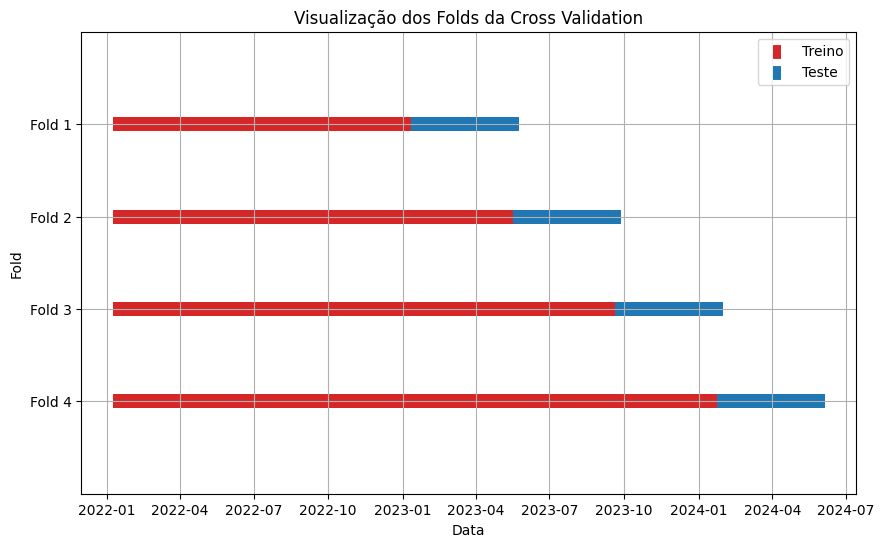

In [56]:
### FUNÇÃO PARA PLOTAR OS FOLDS OBTIDOS COM O SPLIT
def plot_cross_valid(cv_obj, X, y, datas, ax):

    n_splits = cv_obj.get_n_splits()
    
    for i, (train_index, test_index) in enumerate(cv_obj.split(X)):
        ax.scatter(datas[train_index], [i + 0.5] * len(train_index), c='tab:red', marker='_', lw=10, label='Treino' if i == 0 else "")
        ax.scatter(datas[test_index], [i + 0.5] * len(test_index), c='tab:blue', marker='_', lw=10, label='Teste' if i == 0 else "")
    
    ax.set(ylim=[n_splits + 0.5, -0.5], title='Visualização dos Folds da Cross Validation', xlabel='Data', ylabel='Fold')
    ax.legend(loc='best')
    ax.set_yticks(np.arange(n_splits) + 0.5)
    ax.set_yticklabels([f'Fold {i + 1}' for i in range(n_splits)])
    ax.grid(True)
    return ax

### PLOT DOS FOLDS OBTIDOS COM O SPLIT
fig, ax = plt.subplots(figsize=(10, 6))
datas = X_gasolina['ds']
plot_cross_valid(tscv, X_gasolina, y_gasolina, datas, ax)
plt.show()

# **TREINAMENTO DOS MODELOS USANDO CROSS-VALIDATION**

In [57]:
### REMOÇÃO DE COLUNAS NÃO SUPORTADAS PELOS MODELOS: DATA E STRING
X_etanol.drop(columns=['ds', 'unique_id'], inplace=True)
X_gasolina.drop(columns=['ds', 'unique_id'], inplace=True)

## ARIMA


### ETANOL

In [77]:
## REALIZAÇÃO DO TREINO DO MODELO, PREVISÃO E ARMAZENAMENTO DOS RESULTADOS/SCORES
i=0
rmse_scores_etanol = []
mae_scores_etanol = []
preco_etanol_real = []
preco_etanol_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_etanol):
    X_etanol_train, X_etanol_test = X_etanol.iloc[train_index], X_etanol.iloc[test_index]
    y_etanol_train, y_etanol_test = y_etanol.iloc[train_index], y_etanol.iloc[test_index]

    ### TREINAMENTO DO MODELO
    best_arima_e = auto_arima(y = y_etanol_train, X = X_etanol_train, m = 7)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_etanol = best_arima_e.predict(n_periods = len(X_etanol_test), X = X_etanol_test)
    rmse = root_mean_squared_error(y_etanol_test, y_pred_etanol)
    mae = mean_absolute_error(y_etanol_test, y_pred_etanol)
    print(f"RMSE do FOLD_{i}: {rmse}        ||      MAE do FOLD_{i}: {mae}")
    rmse_scores_etanol.append(rmse)
    mae_scores_etanol.append(mae)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_etanol_real.extend(y_etanol_test)
    preco_etanol_pred.extend(y_pred_etanol)
    i+=1

print(f"\nMédia dos RMSEs: {np.mean(rmse_scores_etanol)}        ||      Média dos MAEs: {np.mean(mae_scores_etanol)}")

RMSE do FOLD_0: 0.06739947530540295        ||      MAE do FOLD_0: 0.050367575226372835
RMSE do FOLD_1: 0.07038075736022822        ||      MAE do FOLD_1: 0.057512805033273974
RMSE do FOLD_2: 0.059695436388491056        ||      MAE do FOLD_2: 0.046128755832351466
RMSE do FOLD_3: 0.09866334095759868        ||      MAE do FOLD_3: 0.07684603363615249

Média dos RMSEs: 0.07403475250293023        ||      Média dos MAEs: 0.05771379243203768


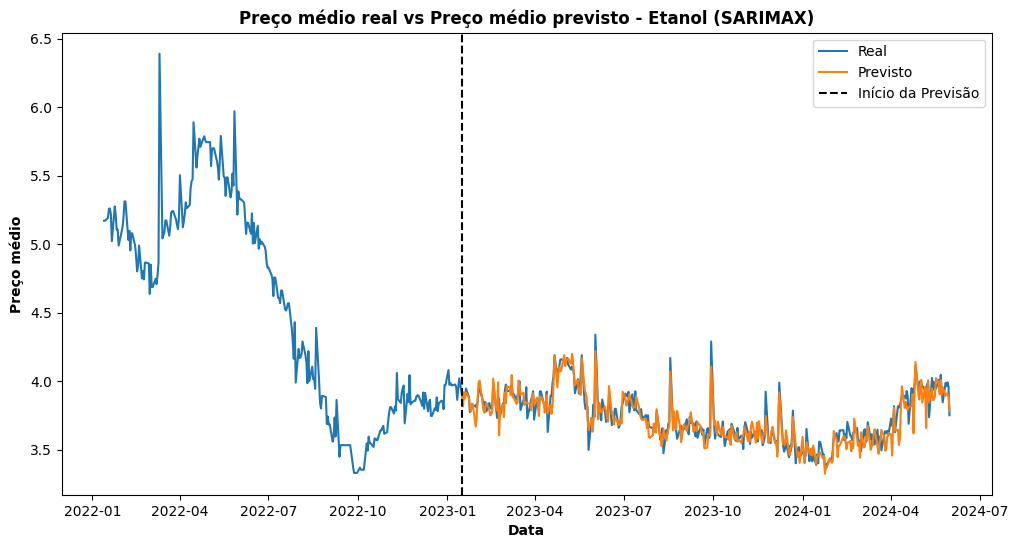

In [78]:
datas_pred_etanol = pd.concat(fold['ds'] for fold in folds_teste_etanol)  
resultados_etanol = pd.DataFrame({
    'data': datas_pred_etanol,
    'real': preco_etanol_real,
    'prediction': preco_etanol_pred
})

### PLOT PARA AVALIAÇÃO DOS RESULTADOS
plt.figure(figsize=(12, 6))
plt.plot(df_fuels[df_fuels['unique_id'] == 'ETANOL']['ds'], y_etanol, label='Real')
plt.plot(resultados_etanol['data'], resultados_etanol['prediction'], label='Previsto', alpha=1.0)
plt.axvline(x=resultados_etanol['data'].min(), color='black', linestyle='--', label='Início da Previsão')
plt.xlabel('Data', fontweight='bold')
plt.ylabel('Preço médio', fontweight='bold')
plt.title('Preço médio real vs Preço médio previsto - Etanol (SARIMAX)', fontweight='bold')
plt.legend()
plt.show()

### GASOLINA

In [79]:
## REALIZAÇÃO DO TREINO DO MODELO, PREVISÃO E ARMAZENAMENTO DOS RESULTADOS/SCORES
i=0
rmse_scores_gasolina = []
mae_scores_gasolina = []
preco_gasolina_real = []
preco_gasolina_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_gasolina):
    X_gasolina_train, X_gasolina_test = X_gasolina.iloc[train_index], X_gasolina.iloc[test_index]
    y_gasolina_train, y_gasolina_test = y_gasolina.iloc[train_index], y_gasolina.iloc[test_index]

    ### TREINAMENTO DO MODELO
    best_arima_g = auto_arima(y = y_gasolina_train, X = X_gasolina_train, m = 7)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_gasolina = best_arima_g.predict(n_periods = len(X_gasolina_test), X = X_gasolina_test)
    rmse = root_mean_squared_error(y_gasolina_test, y_pred_gasolina)
    mae = mean_absolute_error(y_gasolina_test, y_pred_gasolina)
    print(f"RMSE do FOLD_{i}: {rmse}        ||      MAE do FOLD_{i}: {mae}")
    rmse_scores_gasolina.append(rmse)
    mae_scores_gasolina.append(mae)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_gasolina_real.extend(y_gasolina_test)
    preco_gasolina_pred.extend(y_pred_gasolina)
    i+=1

print(f"\nMédia dos RMSEs: {np.mean(rmse_scores_gasolina)}        ||      Média dos MAEs: {np.mean(mae_scores_gasolina)}")

RMSE do FOLD_0: 0.06982764874636432        ||      MAE do FOLD_0: 0.051129842308173926
RMSE do FOLD_1: 0.08185390411885334        ||      MAE do FOLD_1: 0.06027700434880442
RMSE do FOLD_2: 0.08984259423324045        ||      MAE do FOLD_2: 0.06719300450972705
RMSE do FOLD_3: 0.06957875109755604        ||      MAE do FOLD_3: 0.056899921029804054

Média dos RMSEs: 0.07777572454900354        ||      Média dos MAEs: 0.05887494304912737


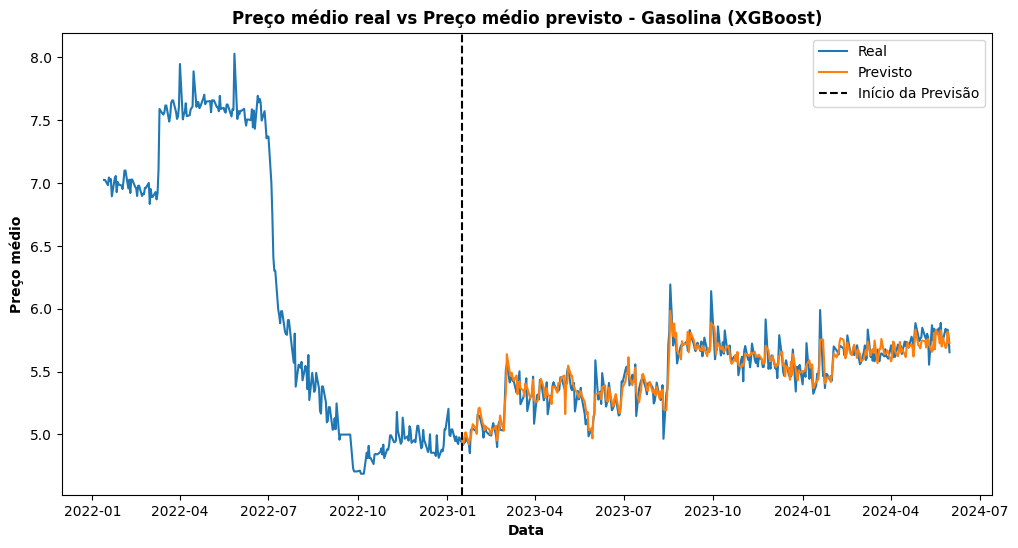

In [80]:
### DATAFRAME PARA AVALIAÇÃO DOS RESULTADOS

datas_pred_gasolina = pd.concat(fold['ds'] for fold in folds_teste_gasolina)  
resultados_gasolina = pd.DataFrame({
    'data': datas_pred_gasolina,
    'real': preco_gasolina_real,
    'prediction': preco_gasolina_pred
})

### PLOT PARA AVALIAÇÃO DOS RESULTADOS
plt.figure(figsize=(12, 6))
plt.plot(df_fuels[df_fuels['unique_id'] == 'GASOLINA']['ds'], y_gasolina, label='Real')
plt.plot(resultados_gasolina['data'], resultados_gasolina['prediction'], label='Previsto', alpha=1.0)
plt.axvline(x=resultados_gasolina['data'].min(), color='black', linestyle='--', label='Início da Previsão')
plt.xlabel('Data', fontweight='bold')
plt.ylabel('Preço médio', fontweight='bold')
plt.title('Preço médio real vs Preço médio previsto - Gasolina (XGBoost)', fontweight='bold')
plt.legend()
plt.show()

## RANDOM FOREST

In [81]:
params_rf = {
    'n_estimators': 1000,
    'max_depth': 10,
    'min_samples_split': 10,
    'min_samples_leaf': 10
}

rf_model_g = RandomForestRegressor(**params_rf)
rf_model_e = RandomForestRegressor(**params_rf)

### ETANOL

In [82]:
## REALIZAÇÃO DO TREINO DO MODELO, PREVISÃO E ARMAZENAMENTO DOS RESULTADOS/SCORES
i=0
rmse_scores_etanol = []
mae_scores_etanol = []
preco_etanol_real = []
preco_etanol_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_etanol):
    X_etanol_train, X_etanol_test = X_etanol.iloc[train_index], X_etanol.iloc[test_index]
    y_etanol_train, y_etanol_test = y_etanol.iloc[train_index], y_etanol.iloc[test_index]

    ### TREINAMENTO DO MODELO
    rf_model_e.fit(X_etanol_train, y_etanol_train)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_etanol = rf_model_e.predict(X_etanol_test)
    rmse = root_mean_squared_error(y_etanol_test, y_pred_etanol)
    mae = mean_absolute_error(y_etanol_test, y_pred_etanol)
    print(f"RMSE do FOLD_{i}: {rmse}        ||      MAE do FOLD_{i}: {mae}")
    rmse_scores_etanol.append(rmse)
    mae_scores_etanol.append(mae)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_etanol_real.extend(y_etanol_test)
    preco_etanol_pred.extend(y_pred_etanol)
    i+=1

print(f"\nMédia dos RMSEs: {np.mean(rmse_scores_etanol)}        ||      Média dos MAEs: {np.mean(mae_scores_etanol)}")

RMSE do FOLD_0: 0.08020523240900325        ||      MAE do FOLD_0: 0.055848854355888516
RMSE do FOLD_1: 0.11691473081352925        ||      MAE do FOLD_1: 0.08018626744618246
RMSE do FOLD_2: 0.09467132060871164        ||      MAE do FOLD_2: 0.07250044224864342
RMSE do FOLD_3: 0.07200696879891647        ||      MAE do FOLD_3: 0.05700503662504062

Média dos RMSEs: 0.09094956315754016        ||      Média dos MAEs: 0.06638515016893876


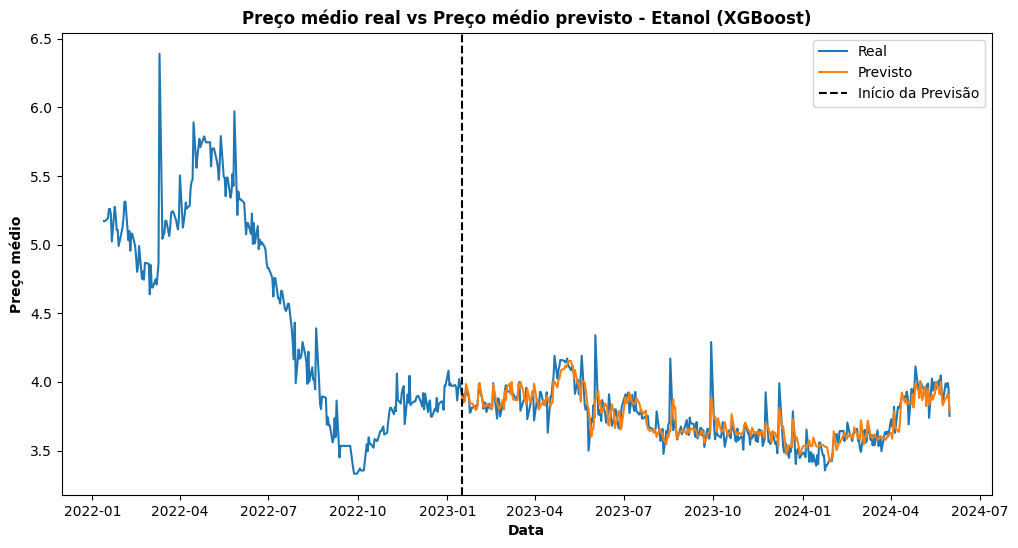

In [83]:
datas_pred_etanol = pd.concat(fold['ds'] for fold in folds_teste_etanol)  
resultados_etanol = pd.DataFrame({
    'data': datas_pred_etanol,
    'real': preco_etanol_real,
    'prediction': preco_etanol_pred
})

### PLOT PARA AVALIAÇÃO DOS RESULTADOS
plt.figure(figsize=(12, 6))
plt.plot(df_fuels[df_fuels['unique_id'] == 'ETANOL']['ds'], y_etanol, label='Real')
plt.plot(resultados_etanol['data'], resultados_etanol['prediction'], label='Previsto', alpha=1.0)
plt.axvline(x=resultados_etanol['data'].min(), color='black', linestyle='--', label='Início da Previsão')
plt.xlabel('Data', fontweight='bold')
plt.ylabel('Preço médio', fontweight='bold')
plt.title('Preço médio real vs Preço médio previsto - Etanol (XGBoost)', fontweight='bold')
plt.legend()
plt.show()

### GASOLINA

In [84]:
## REALIZAÇÃO DO TREINO DO MODELO, PREVISÃO E ARMAZENAMENTO DOS RESULTADOS/SCORES
i=0
rmse_scores_gasolina = []
mae_scores_gasolina = []
preco_gasolina_real = []
preco_gasolina_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_gasolina):
    X_gasolina_train, X_gasolina_test = X_gasolina.iloc[train_index], X_gasolina.iloc[test_index]
    y_gasolina_train, y_gasolina_test = y_gasolina.iloc[train_index], y_gasolina.iloc[test_index]

    ### TREINAMENTO DO MODELO
    rf_model_g.fit(X_gasolina_train, y_gasolina_train)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_gasolina = rf_model_g.predict(X_gasolina_test)
    rmse = root_mean_squared_error(y_gasolina_test, y_pred_gasolina)
    mae = mean_absolute_error(y_gasolina_test, y_pred_gasolina)
    print(f"RMSE do FOLD_{i}: {rmse}        ||      MAE do FOLD_{i}: {mae}")
    rmse_scores_gasolina.append(rmse)
    mae_scores_gasolina.append(mae)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_gasolina_real.extend(y_gasolina_test)
    preco_gasolina_pred.extend(y_pred_gasolina)
    i+=1

print(f"\nMédia dos RMSEs: {np.mean(rmse_scores_gasolina)}        ||      Média dos MAEs: {np.mean(mae_scores_gasolina)}")

RMSE do FOLD_0: 0.11017949483155867        ||      MAE do FOLD_0: 0.08080229932666769
RMSE do FOLD_1: 0.12781015111052138        ||      MAE do FOLD_1: 0.09712593700799894
RMSE do FOLD_2: 0.13143326298978597        ||      MAE do FOLD_2: 0.0960530696715731
RMSE do FOLD_3: 0.08131033268333845        ||      MAE do FOLD_3: 0.06463075674517896

Média dos RMSEs: 0.11268331040380111        ||      Média dos MAEs: 0.08465301568785466


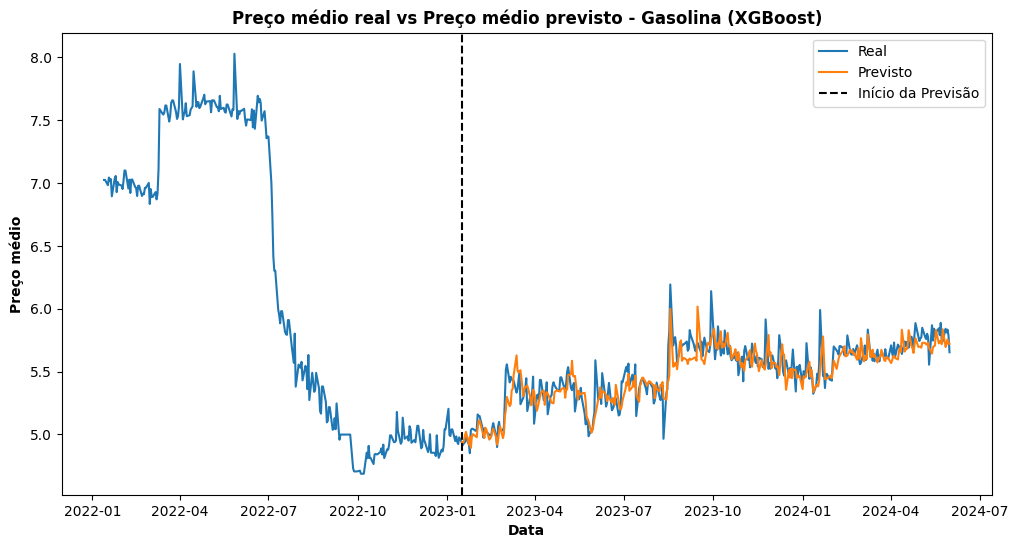

In [85]:
### DATAFRAME PARA AVALIAÇÃO DOS RESULTADOS

datas_pred_gasolina = pd.concat(fold['ds'] for fold in folds_teste_gasolina)  
resultados_gasolina = pd.DataFrame({
    'data': datas_pred_gasolina,
    'real': preco_gasolina_real,
    'prediction': preco_gasolina_pred
})

### PLOT PARA AVALIAÇÃO DOS RESULTADOS
plt.figure(figsize=(12, 6))
plt.plot(df_fuels[df_fuels['unique_id'] == 'GASOLINA']['ds'], y_gasolina, label='Real')
plt.plot(resultados_gasolina['data'], resultados_gasolina['prediction'], label='Previsto', alpha=1.0)
plt.axvline(x=resultados_gasolina['data'].min(), color='black', linestyle='--', label='Início da Previsão')
plt.xlabel('Data', fontweight='bold')
plt.ylabel('Preço médio', fontweight='bold')
plt.title('Preço médio real vs Preço médio previsto - Gasolina (XGBoost)', fontweight='bold')
plt.legend()
plt.show()

## XGBOOST

In [86]:
## DEFINIÇÃO DOS PARÂMETROS DO MODELO E DO OBJETO DO XGBOOST REGRESSOR
params_xgb = {
    'objective': 'reg:squarederror',
    'eval_metric': 'rmse',
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 1000
}

xgb_model_g = XGBRegressor(**params_xgb)
xgb_model_e = XGBRegressor(**params_xgb)

### ETANOL

In [87]:
## REALIZAÇÃO DO TREINO DO MODELO, PREVISÃO E ARMAZENAMENTO DOS RESULTADOS/SCORES
i=0
rmse_scores_etanol = []
mae_scores_etanol = []
preco_etanol_real = []
preco_etanol_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_etanol):
    X_etanol_train, X_etanol_test = X_etanol.iloc[train_index], X_etanol.iloc[test_index]
    y_etanol_train, y_etanol_test = y_etanol.iloc[train_index], y_etanol.iloc[test_index]

    ### TREINAMENTO DO MODELO
    xgb_model_e.fit(X_etanol_train, y_etanol_train)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_etanol = xgb_model_e.predict(X_etanol_test)
    rmse = root_mean_squared_error(y_etanol_test, y_pred_etanol)
    mae = mean_absolute_error(y_etanol_test, y_pred_etanol)
    print(f"RMSE do FOLD_{i}: {rmse}        ||      MAE do FOLD_{i}: {mae}")
    rmse_scores_etanol.append(rmse)
    mae_scores_etanol.append(mae)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_etanol_real.extend(y_etanol_test)
    preco_etanol_pred.extend(y_pred_etanol)
    i+=1

print(f"\nMédia dos RMSEs: {np.mean(rmse_scores_etanol)}        ||      Média dos MAEs: {np.mean(mae_scores_etanol)}")

RMSE do FOLD_0: 0.07401570747430865        ||      MAE do FOLD_0: 0.05880394222007933
RMSE do FOLD_1: 0.09253512172344014        ||      MAE do FOLD_1: 0.06776577060208641
RMSE do FOLD_2: 0.11474128710660918        ||      MAE do FOLD_2: 0.0940272977138541
RMSE do FOLD_3: 0.0728128059110023        ||      MAE do FOLD_3: 0.05835065189973307

Média dos RMSEs: 0.08852623055384007        ||      Média dos MAEs: 0.06973691560893822


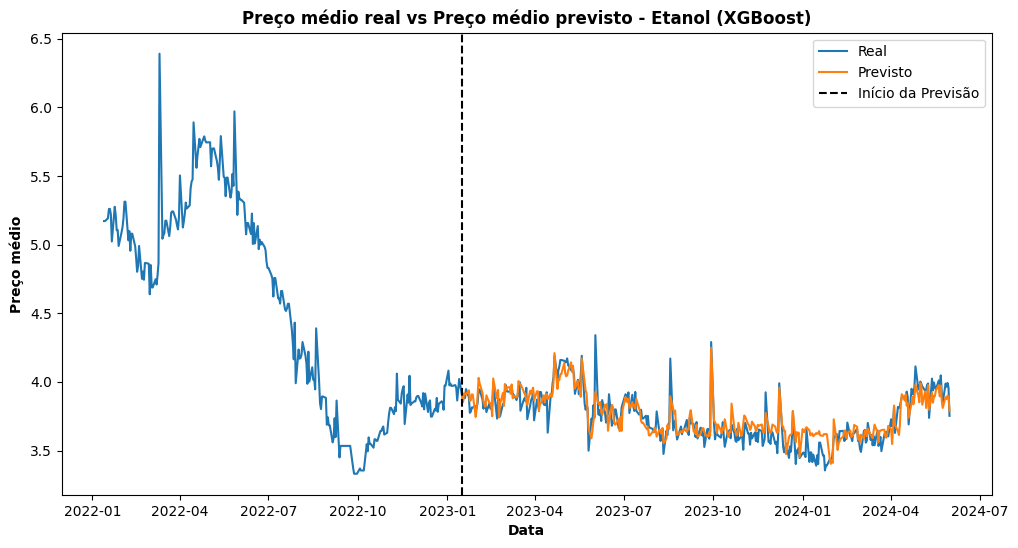

In [88]:
datas_pred_etanol = pd.concat(fold['ds'] for fold in folds_teste_etanol)  
resultados_etanol = pd.DataFrame({
    'data': datas_pred_etanol,
    'real': preco_etanol_real,
    'prediction': preco_etanol_pred
})

### PLOT PARA AVALIAÇÃO DOS RESULTADOS
plt.figure(figsize=(12, 6))
plt.plot(df_fuels[df_fuels['unique_id'] == 'ETANOL']['ds'], y_etanol, label='Real')
plt.plot(resultados_etanol['data'], resultados_etanol['prediction'], label='Previsto', alpha=1.0)
plt.axvline(x=resultados_etanol['data'].min(), color='black', linestyle='--', label='Início da Previsão')
plt.xlabel('Data', fontweight='bold')
plt.ylabel('Preço médio', fontweight='bold')
plt.title('Preço médio real vs Preço médio previsto - Etanol (XGBoost)', fontweight='bold')
plt.legend()
plt.show()

### GASOLINA

In [89]:
## REALIZAÇÃO DO TREINO DO MODELO, PREVISÃO E ARMAZENAMENTO DOS RESULTADOS/SCORES
i=0
rmse_scores_gasolina = []
mae_scores_gasolina = []
preco_gasolina_real = []
preco_gasolina_pred = []

### LOOP PARA TREINO E PREDIÇÃO UTILIZANDO CROSS-VALIDATION DE SÉRIES TEMPORAIS
for train_index, test_index in tscv.split(X_gasolina):
    X_gasolina_train, X_gasolina_test = X_gasolina.iloc[train_index], X_gasolina.iloc[test_index]
    y_gasolina_train, y_gasolina_test = y_gasolina.iloc[train_index], y_gasolina.iloc[test_index]

    ### TREINAMENTO DO MODELO
    xgb_model_g.fit(X_gasolina_train, y_gasolina_train)

    ### PREDIÇÃO E CÁLCULO DO RMSE
    y_pred_gasolina = xgb_model_g.predict(X_gasolina_test)
    rmse = root_mean_squared_error(y_gasolina_test, y_pred_gasolina)
    mae = mean_absolute_error(y_gasolina_test, y_pred_gasolina)
    print(f"RMSE do FOLD_{i}: {rmse}        ||      MAE do FOLD_{i}: {mae}")
    rmse_scores_gasolina.append(rmse)
    mae_scores_gasolina.append(mae)

    ### ARMAZENAMENTO DOS RESULTADOS
    preco_gasolina_real.extend(y_gasolina_test)
    preco_gasolina_pred.extend(y_pred_gasolina)
    i+=1

print(f"\nMédia dos RMSEs: {np.mean(rmse_scores_gasolina)}        ||      Média dos MAEs: {np.mean(mae_scores_gasolina)}")

RMSE do FOLD_0: 0.1306098349406286        ||      MAE do FOLD_0: 0.10952191316658393
RMSE do FOLD_1: 0.12822221714689716        ||      MAE do FOLD_1: 0.07640773293604775
RMSE do FOLD_2: 0.10892347883769006        ||      MAE do FOLD_2: 0.08829340840122901
RMSE do FOLD_3: 0.08640481548087545        ||      MAE do FOLD_3: 0.07038350596004972

Média dos RMSEs: 0.11354008660152282        ||      Média dos MAEs: 0.0861516401159776


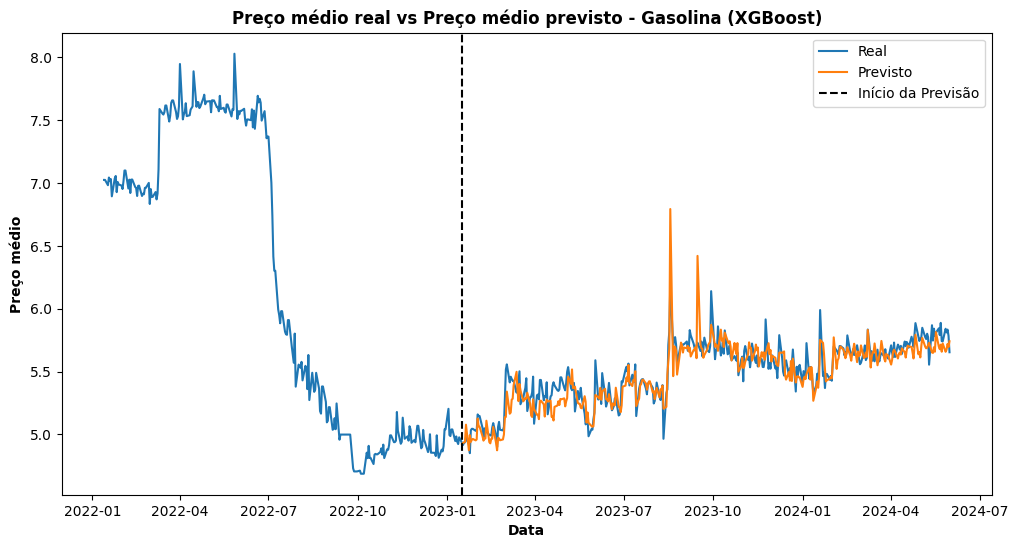

In [90]:
### DATAFRAME PARA AVALIAÇÃO DOS RESULTADOS

datas_pred_gasolina = pd.concat(fold['ds'] for fold in folds_teste_gasolina)  
resultados_gasolina = pd.DataFrame({
    'data': datas_pred_gasolina,
    'real': preco_gasolina_real,
    'prediction': preco_gasolina_pred
})

### PLOT PARA AVALIAÇÃO DOS RESULTADOS
plt.figure(figsize=(12, 6))
plt.plot(df_fuels[df_fuels['unique_id'] == 'GASOLINA']['ds'], y_gasolina, label='Real')
plt.plot(resultados_gasolina['data'], resultados_gasolina['prediction'], label='Previsto', alpha=1.0)
plt.axvline(x=resultados_gasolina['data'].min(), color='black', linestyle='--', label='Início da Previsão')
plt.xlabel('Data', fontweight='bold')
plt.ylabel('Preço médio', fontweight='bold')
plt.title('Preço médio real vs Preço médio previsto - Gasolina (XGBoost)', fontweight='bold')
plt.legend()
plt.show()

# **OTIMIZAÇÃO DE HIPERPARÂMETROS**

In [95]:
def objective(trial, X, y, modelo):
    if modelo == 'xgboost':
        params = {
        "objective": "reg:squarederror",
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, log=True),
        "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 2, 20)
        }
        
        model = XGBRegressor(**params)
    
    elif modelo == 'random_forest':
        params = {
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000, log=True),
        "min_samples_leaf": trial.suggest_int("min_samples_leaf", 1, 10),
        "min_samples_split": trial.suggest_int("min_samples_split", 2, 10),
        "max_depth": trial.suggest_int("max_depth", 2, 20)
        }

        model = RandomForestRegressor(**params)

    rmse_opt = []

    for train_index, test_index in tscv.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        
        ### TREINAMENTO DO MODELO
        model.fit(X_train, y_train)
        
        ### PREDIÇÃO E CÁLCULO DO RMSE
        y_pred = model.predict(X_test)
        rmse = root_mean_squared_error(y_test, y_pred)
        rmse_opt.append(rmse)

    return np.mean(rmse_opt)

In [96]:
def run_optimize(X, y, modelo, n):
    study = optuna.create_study(direction='minimize')
    study.optimize(lambda trial: objective(trial, X, y, modelo), n_trials=n)

    print(f"Melhores parâmetros para o modelo {modelo}: {study.best_params}")
    print("_________________________________________________________________")
    return study.best_params

In [98]:
best_params_rf_e = run_optimize(X_etanol, y_etanol, modelo='random_forest', n=50)
best_params_rf_g = run_optimize(X_gasolina, y_gasolina, modelo='random_forest', n=50)

best_params_xgb_e = run_optimize(X_etanol, y_etanol, modelo='xgboost', n=50)
best_params_xgb_g = run_optimize(X_gasolina, y_gasolina, modelo='xgboost', n=50)

[I 2024-10-15 19:08:48,111] A new study created in memory with name: no-name-1efba9c7-0b43-4090-8c62-58e272eebc28
[I 2024-10-15 19:08:51,087] Trial 0 finished with value: 0.09276924010557674 and parameters: {'n_estimators': 197, 'min_samples_leaf': 3, 'min_samples_split': 10, 'max_depth': 5}. Best is trial 0 with value: 0.09276924010557674.
[I 2024-10-15 19:08:57,245] Trial 1 finished with value: 0.12357519841139572 and parameters: {'n_estimators': 622, 'min_samples_leaf': 6, 'min_samples_split': 3, 'max_depth': 2}. Best is trial 0 with value: 0.09276924010557674.
[I 2024-10-15 19:09:05,319] Trial 2 finished with value: 0.09091399915408027 and parameters: {'n_estimators': 519, 'min_samples_leaf': 10, 'min_samples_split': 7, 'max_depth': 9}. Best is trial 2 with value: 0.09091399915408027.
[I 2024-10-15 19:09:15,685] Trial 3 finished with value: 0.09744534842157189 and parameters: {'n_estimators': 793, 'min_samples_leaf': 2, 'min_samples_split': 9, 'max_depth': 4}. Best is trial 2 with 

Melhores parâmetros para o modelo random_forest: {'n_estimators': 371, 'min_samples_leaf': 8, 'min_samples_split': 9, 'max_depth': 7}
_________________________________________________________________


[I 2024-10-15 19:14:41,994] Trial 0 finished with value: 0.11556529888117825 and parameters: {'n_estimators': 446, 'min_samples_leaf': 7, 'min_samples_split': 4, 'max_depth': 5}. Best is trial 0 with value: 0.11556529888117825.
[I 2024-10-15 19:14:47,713] Trial 1 finished with value: 0.3273431981758745 and parameters: {'n_estimators': 737, 'min_samples_leaf': 1, 'min_samples_split': 5, 'max_depth': 1}. Best is trial 0 with value: 0.11556529888117825.
[I 2024-10-15 19:14:51,281] Trial 2 finished with value: 0.10958727681556404 and parameters: {'n_estimators': 192, 'min_samples_leaf': 2, 'min_samples_split': 10, 'max_depth': 10}. Best is trial 2 with value: 0.10958727681556404.
[I 2024-10-15 19:14:59,606] Trial 3 finished with value: 0.11288139429785816 and parameters: {'n_estimators': 621, 'min_samples_leaf': 10, 'min_samples_split': 2, 'max_depth': 5}. Best is trial 2 with value: 0.10958727681556404.
[I 2024-10-15 19:15:00,689] Trial 4 finished with value: 0.17725382501968248 and param

Melhores parâmetros para o modelo random_forest: {'n_estimators': 229, 'min_samples_leaf': 1, 'min_samples_split': 10, 'max_depth': 8}
_________________________________________________________________


[I 2024-10-15 19:19:43,904] Trial 0 finished with value: 0.3419464989954059 and parameters: {'n_estimators': 250, 'learning_rate': 0.0022980831772203975, 'max_depth': 4}. Best is trial 0 with value: 0.3419464989954059.
[I 2024-10-15 19:19:53,768] Trial 1 finished with value: 0.09300048934320532 and parameters: {'n_estimators': 389, 'learning_rate': 0.023693335400749062, 'max_depth': 10}. Best is trial 1 with value: 0.09300048934320532.
[I 2024-10-15 19:19:57,534] Trial 2 finished with value: 0.3013702678892087 and parameters: {'n_estimators': 253, 'learning_rate': 0.0028931177735954444, 'max_depth': 10}. Best is trial 1 with value: 0.09300048934320532.
[I 2024-10-15 19:19:58,825] Trial 3 finished with value: 0.08226210427289306 and parameters: {'n_estimators': 302, 'learning_rate': 0.05368503647821435, 'max_depth': 1}. Best is trial 3 with value: 0.08226210427289306.
[I 2024-10-15 19:20:03,943] Trial 4 finished with value: 0.09177058281871957 and parameters: {'n_estimators': 496, 'lear

Melhores parâmetros para o modelo xgboost: {'n_estimators': 255, 'learning_rate': 0.04635101617772876, 'max_depth': 2}
_________________________________________________________________


[I 2024-10-15 19:22:29,175] Trial 0 finished with value: 0.12307039486360974 and parameters: {'n_estimators': 858, 'learning_rate': 0.046426023782206415, 'max_depth': 9}. Best is trial 0 with value: 0.12307039486360974.
[I 2024-10-15 19:22:31,120] Trial 1 finished with value: 0.10701155029776839 and parameters: {'n_estimators': 313, 'learning_rate': 0.053597932588784945, 'max_depth': 3}. Best is trial 1 with value: 0.10701155029776839.
[I 2024-10-15 19:22:33,842] Trial 2 finished with value: 0.10817662472404467 and parameters: {'n_estimators': 348, 'learning_rate': 0.009645743015900902, 'max_depth': 4}. Best is trial 1 with value: 0.10701155029776839.
[I 2024-10-15 19:22:42,203] Trial 3 finished with value: 0.11441123465060005 and parameters: {'n_estimators': 668, 'learning_rate': 0.004382364782310901, 'max_depth': 7}. Best is trial 1 with value: 0.10701155029776839.
[I 2024-10-15 19:22:45,162] Trial 4 finished with value: 0.0963270862046715 and parameters: {'n_estimators': 625, 'learn

Melhores parâmetros para o modelo xgboost: {'n_estimators': 464, 'learning_rate': 0.03630275596457086, 'max_depth': 2}
_________________________________________________________________


In [100]:
best_params_xgb_e = run_optimize(X_etanol, y_etanol, modelo='xgboost', n=50)
best_params_xgb_g = run_optimize(X_gasolina, y_gasolina, modelo='xgboost', n=50)

[I 2024-10-15 19:40:06,602] A new study created in memory with name: no-name-7a51a804-eaf6-4892-be00-68a12ee2cdf9
[I 2024-10-15 19:40:13,766] Trial 0 finished with value: 0.23097660225193567 and parameters: {'n_estimators': 481, 'learning_rate': 0.0022479657061979137, 'max_depth': 9}. Best is trial 0 with value: 0.23097660225193567.
[I 2024-10-15 19:40:17,227] Trial 1 finished with value: 0.39944042989008616 and parameters: {'n_estimators': 270, 'learning_rate': 0.0015182455608107651, 'max_depth': 9}. Best is trial 0 with value: 0.23097660225193567.
[I 2024-10-15 19:40:19,478] Trial 2 finished with value: 0.24874194035528643 and parameters: {'n_estimators': 247, 'learning_rate': 0.00391876893607414, 'max_depth': 5}. Best is trial 0 with value: 0.23097660225193567.
[I 2024-10-15 19:40:25,793] Trial 3 finished with value: 0.2458052199671646 and parameters: {'n_estimators': 427, 'learning_rate': 0.002332316770836942, 'max_depth': 10}. Best is trial 0 with value: 0.23097660225193567.
[I 20

Melhores parâmetros para o modelo xgboost: {'n_estimators': 329, 'learning_rate': 0.026407531698790516, 'max_depth': 2}
_________________________________________________________________


[I 2024-10-15 19:42:11,280] Trial 0 finished with value: 0.10963731399315842 and parameters: {'n_estimators': 242, 'learning_rate': 0.010055728868925784, 'max_depth': 4}. Best is trial 0 with value: 0.10963731399315842.
[I 2024-10-15 19:42:13,669] Trial 1 finished with value: 0.10986632132567087 and parameters: {'n_estimators': 569, 'learning_rate': 0.01608085971140591, 'max_depth': 1}. Best is trial 0 with value: 0.10963731399315842.
[I 2024-10-15 19:42:22,234] Trial 2 finished with value: 0.12292390604167369 and parameters: {'n_estimators': 391, 'learning_rate': 0.029362241978760868, 'max_depth': 10}. Best is trial 0 with value: 0.10963731399315842.
[I 2024-10-15 19:42:24,019] Trial 3 finished with value: 0.27497343819633374 and parameters: {'n_estimators': 143, 'learning_rate': 0.004191626571770282, 'max_depth': 8}. Best is trial 0 with value: 0.10963731399315842.
[I 2024-10-15 19:42:28,441] Trial 4 finished with value: 0.24920386266394892 and parameters: {'n_estimators': 354, 'lear

Melhores parâmetros para o modelo xgboost: {'n_estimators': 605, 'learning_rate': 0.03141913922934147, 'max_depth': 2}
_________________________________________________________________
